#  NOAA Weather Data of JFK Airport (New York)
### monthly Rainforecast
This notebook relates to the NOAA Weather Dataset - JFK Airport (New York). The dataset contains 114,546 hourly observations of 12 local climatological variables (such as temperature and wind speed) collected at JFK airport. This dataset can be obtained for free from the IBM Developer [Data Asset Exchange](https://developer.ibm.com/exchanges/data/all/jfk-weather-data/).

In this notebook, we clean the raw dataset by:
* removing redundant columns and preserving only key numeric columns
* converting and cleaning data where required
* creating a fixed time interval between observations (this aids with later time-series analysis)
* filling missing values
* encoding certain weather features

### Table of Contents:
* [0. Prerequisites](#cell0)
* [1. Read the Raw Data](#cell1)
* [2. Clean the Data](#cell2)
  * [2.1 Select data columns](#cell3)
  * [2.2 Clean up precipitation column](#cell4)
  * [2.3 Convert columns to numerical types](#cell5)
  * [2.4 Reformat and process data](#cell6)
  * [2.5 Create a fixed interval dataset](#cell7)
  * [2.6 Feature encoding](#cell8)
  * [2.7 Rename columns](#cell9)
* [3. Save the Cleaned Data](#cell10)
* [Authors](#authors)

<a id="cell0"></a>
### 0. Prerequisites

Before you run this notebook complete the following steps:
- Insert a project token
- Import required modules

#### Insert a project token

When you import this project from the Watson Studio Gallery, a token should be automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the dataset from the project's resources:

* Click on `More -> Insert project token` in the top-right menu section

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below

#### Import required modules

Import and configure the required modules.

In [506]:
!ls

FabirxSensor8x8.ipynb                   input_data.xlsx
Krakow_2007_2018.csv                    jfk_weather.csv
LICENSE                                 jfk_weather.csv 2.zip
MontlyRainPredictions.ipynb             jfk_weather.csv.zip
Part 1 - Data Cleaning (1).ipynb        jfk_weather_cleaned.csv
README.md                               jfk_weather_cleaned.csv.zip
Untitled.ipynb                          machine-learning-predict-weather-master
Untitled1.ipynb                         model_selection.ipynb
WU-Ground                               open_csv.py
Weather_forecasting-master              realtimeplottingtest.ipynb
exploratory_analysis.ipynb              requirements.txt
fabfabric-5.csv                         results.xlsx
forecast.ipynb                          tensorflow-lstm-regression-master


In [507]:
# Define required imports
import pandas as pd
import numpy as np
import sys
import re
# These set pandas max column and row display in the notebook
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

<a id="cell1"></a>

### 1. Read the Raw Data

We start by reading in the raw dataset, displaying the first few rows of the dataframe, and taking a look at the columns and column types present.

In [508]:
# define filename
DATA_PATH = 'jfk_weather.csv'
#based on https://dataplatform.cloud.ibm.com/exchange/public/entry/view/a7432f0c29c5bda2fb42749f363bd9ff
#DATA_PATH='https://github.com/markusvankempen/ThinkLab1239/blob/master/data/jfk_weather.csv.zip?raw=true'
#raw_data = pd.read_csv(DATA_PATH, parse_dates=['DATE'])
#raw_data.head()

import pandas as pd
import io
import requests
url="https://github.com/markusvankempen/ThinkLab1239/blob/master/data/jfk_weather.csv.zip?raw=true"
#s=requests.get(url).content
raw_data=pd.read_csv(url, compression='zip')

raw_data.head()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,20,22,23,25,40,63,64,67,68,69,84,85,86,87) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,HOURLYDRYBULBTEMPF,HOURLYDRYBULBTEMPC,HOURLYWETBULBTEMPF,HOURLYWETBULBTEMPC,HOURLYDewPointTempF,HOURLYDewPointTempC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYWindGustSpeed,HOURLYStationPressure,HOURLYPressureTendency,HOURLYPressureChange,HOURLYSeaLevelPressure,HOURLYPrecip,...,MonthlyGreatestPrecip,MonthlyGreatestPrecipDate,MonthlyGreatestSnowfall,MonthlyGreatestSnowfallDate,MonthlyGreatestSnowDepth,MonthlyGreatestSnowDepthDate,MonthlyDaysWithGT90Temp,MonthlyDaysWithLT32Temp,MonthlyDaysWithGT32Temp,MonthlyDaysWithLT0Temp,MonthlyDaysWithGT001Precip,MonthlyDaysWithGT010Precip,MonthlyDaysWithGT1Snow,MonthlyMaxSeaLevelPressureValue,MonthlyMaxSeaLevelPressureDate,MonthlyMaxSeaLevelPressureTime,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureDate,MonthlyMinSeaLevelPressureTime,MonthlyTotalHeatingDegreeDays,MonthlyTotalCoolingDegreeDays,MonthlyDeptFromNormalHeatingDD,MonthlyDeptFromNormalCoolingDD,MonthlyTotalSeasonToDateHeatingDD,MonthlyTotalSeasonToDateCoolingDD
0,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 00:51,FM-15,FEW:02 7 SCT:04 13 BKN:07 29,6.00,-RA:02 PL:06 BR:1 |RA:61 PL:74 |RA:61 PL:79,33,0.6,32,0.1,31,-0.6,92,0,000,NaN,29.97,8.0,NaN,29.99,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
1,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 01:00,FM-12,NaN,5.59,||PL:79,33,0.6,32,0.1,31,-0.6,92,0,000,NaN,29.96,8.0,+0.05,29.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
2,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 01:51,FM-15,FEW:02 6 SCT:04 13 OVC:08 35,6.00,-RA:02 PL:06 BR:1 |RA:61 PL:74 |RA:61 PL:79,33,0.6,33,0.3,32,0.0,96,0,000,NaN,29.97,NaN,NaN,29.99,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
3,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 02:03,FM-16,FEW:02 6 SCT:04 13 OVC:08 35,6.00,-RA:02 BR:1 |RA:61 |RA:61,34,1,33,0.7,32,0.0,93,0,000,NaN,29.97,NaN,NaN,NaN,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
4,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,3.4,40.6386,-73.7622,2010-01-01 02:28,FM-16,BKN:07 7 BKN:07 15 OVC:08 35,5.00,-RA:02 BR:1 |RA:61 |RA:61,34,1,33,0.7,32,0.0,93,0,000,NaN,29.97,NaN,NaN,NaN,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN


In [509]:
raw_data.dtypes

STATION                               object
STATION_NAME                          object
ELEVATION                            float64
LATITUDE                             float64
LONGITUDE                            float64
                                      ...   
MonthlyTotalCoolingDegreeDays         object
MonthlyDeptFromNormalHeatingDD        object
MonthlyDeptFromNormalCoolingDD        object
MonthlyTotalSeasonToDateHeatingDD    float64
MonthlyTotalSeasonToDateCoolingDD    float64
Length: 90, dtype: object

<a id="cell2"></a>

### 2. Clean the Data

As you can see above, there are a lot of fields which are non-numerical - usually these will be fields that contain text or categorical data, e.g. `HOURLYSKYCONDITIONS`.

There are also fields - such as the main temperature field of interest `HOURLYDRYBULBTEMPF` - that we expect to be numerical, but are instead `object` type. This often indicates that there may be missing (or `null`) values, or some other unusual readings that we may have to deal with (since otherwise the field would have been fully parsed as a numerical data type).

In addition, some fields relate to hourly observations, while others relate to daily or monthly intervals. For purposes of later exploratory data analysis, we will restrict the dataset to a certain subset  of numerical fields that relate to hourly observations.

In this section, we refer to the [NOAA Local Climatological Data Documentation](https://data.noaa.gov/dataset/dataset/u-s-local-climatological-data-lcd/resource/ee7381ea-647a-434f-8cfa-81202b9b4c05) to describe the fields and meaning of various values.

<a id="cell3"></a>
#### 2.1 Select data columns

First, we select only the subset of data columns of interest and inspect the column types.

In [510]:
# Choose what columns to import from raw data
column_subset = [
    'DATE',
    'HOURLYVISIBILITY',
    'HOURLYDRYBULBTEMPF',
    'HOURLYWETBULBTEMPF',
    'HOURLYDewPointTempF',
    'HOURLYRelativeHumidity',
    'HOURLYWindSpeed',
    'HOURLYWindDirection',
    'HOURLYStationPressure',
    'HOURLYPressureTendency',
    'HOURLYSeaLevelPressure',
    'HOURLYPrecip',
    'HOURLYAltimeterSetting'
]

# Filter dataset to relevant columns
hourly_data = raw_data[column_subset]
# Set date index
hourly_data = hourly_data.set_index(pd.DatetimeIndex(hourly_data['DATE']))
hourly_data.drop(['DATE'], axis=1, inplace=True)
hourly_data.replace(to_replace='*', value=np.nan, inplace=True)
hourly_data.head()

,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
DATE,,,,,,,,,,,,
2010-01-01 00:51:00,6.00,33,32,31,92,0,000,29.97,8.0,29.99,0.01,29.99
2010-01-01 01:00:00,5.59,33,32,31,92,0,000,29.96,8.0,29.99,NaN,NaN
2010-01-01 01:51:00,6.00,33,33,32,96,0,000,29.97,NaN,29.99,0.02,29.99
2010-01-01 02:03:00,6.00,34,33,32,93,0,000,29.97,NaN,NaN,T,29.99
2010-01-01 02:28:00,5.00,34,33,32,93,0,000,29.97,NaN,NaN,T,29.99


In [511]:
hourly_data.dtypes

HOURLYVISIBILITY           object
HOURLYDRYBULBTEMPF         object
HOURLYWETBULBTEMPF         object
HOURLYDewPointTempF        object
HOURLYRelativeHumidity     object
HOURLYWindSpeed            object
HOURLYWindDirection        object
HOURLYStationPressure      object
HOURLYPressureTendency    float64
HOURLYSeaLevelPressure     object
HOURLYPrecip               object
HOURLYAltimeterSetting     object
dtype: object

<a id="cell4"></a>
#### 2.2 Clean up precipitation column

From the dataframe preview above, we can see that the column `HOURLYPrecip` - which is the hourly measure of precipitation levels - contains both `NaN` and `T` values. `T` specifies *trace amounts of precipitation*, while `NaN` means *not a number*, and is used to denote missing values.

We can also inspect the unique values present for the field.

In [512]:
hourly_data['HOURLYPrecip'].unique()

array(['0.01', nan, '0.02', 'T', '0.00', '0.10', '0.07', '0.03', '0.05',
       '0.15', '0.06', '0.08', '0.04', '0.09', '0.11', '0.20', '0.13',
       '0.14', '0.05s', '0.12', '0.24', '0.02s', '0.17', '0.16', '0.47',
       '0.28', '0.32', '0.19', '0.22', '0.18', '0.26', '0.23', '0.30',
       '0.33', '0.04s', '0.36', '0.40', '0.41', '0.51', '0.50', '0.68s',
       '0.21', '0.35', '0.54', '0.01s', '0.34', '0.94', '1.14', '1.18',
       '1.15', '0.65', '0.74', '0.39', '0.67', '0.29', '0.46', '0.87',
       '1.10', '0.52', '0.08s', '0.37', '0.42', '0.03s', '0.09s', '0.11s',
       '0.10s', '0.25', '0.33s', '0.13s', '0.38', '0.64s', '0.06s',
       '0.17s', '0.69s', '0.73', '2.41', '0.57', '0.84', '0.86', '0.27',
       '0.60', '0.45', '0.75', '1.26', '0.59', '0.68', '0.79', '0.70',
       '0.44', '0.43', '0.53', '0.37s', '0.77', '0.85', '0.93', '0.55',
       '0.56', '1.52', '1.05', '1.76', '0.07s', '0.63', '1.19', '0.12s',
       '0.18s', '0.58', '0.48', '0.66', '0.29s', '0.71', '0.20s'

We can see that some values end with an `s` (indicating snow), while there is a strange value `0.020.01s` which appears to be an error of some sort. To deal with `T` values, we will set the observation to be `0`. We will also replace the erroneous value `0.020.01s` with `NaN`.

In [513]:
# Fix imported data
hourly_data['HOURLYPrecip'].replace(to_replace='T', value='0.00', inplace=True)
hourly_data['HOURLYPrecip'].replace('0.020.01s', np.nan, inplace=True)

<a id="cell5"></a>
#### 2.3 Convert columns to numerical types

Next, we will convert string columns that refer to numerical values to numerical types. For columns such as `HOURLYPrecip`, we first also drop the non-numerical parts of the value (the `s` character).

In [514]:
# Set of columns to convert
messy_columns = column_subset[1:]

# Convert columns to float32 datatype
for i in messy_columns:
    hourly_data[i] = hourly_data[i].apply(lambda x: re.sub('[^0-9,.-]', '', x) if type(x) == str else x).replace('', np.nan).astype(('float32'))

We can now see that all fields have numerical data type.

In [515]:
print(hourly_data.info())
print()
hourly_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114545 entries, 2010-01-01 00:51:00 to 2018-07-27 23:59:00
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   HOURLYVISIBILITY        96464 non-null   float32
 1   HOURLYDRYBULBTEMPF      111403 non-null  float32
 2   HOURLYWETBULBTEMPF      111245 non-null  float32
 3   HOURLYDewPointTempF     111395 non-null  float32
 4   HOURLYRelativeHumidity  111395 non-null  float32
 5   HOURLYWindSpeed         111358 non-null  float32
 6   HOURLYWindDirection     110444 non-null  float32
 7   HOURLYStationPressure   111256 non-null  float32
 8   HOURLYPressureTendency  48038 non-null   float32
 9   HOURLYSeaLevelPressure  99522 non-null   float32
 10  HOURLYPrecip            79762 non-null   float32
 11  HOURLYAltimeterSetting  86878 non-null   float32
dtypes: float32(12)
memory usage: 6.1 MB
None



,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
DATE,,,,,,,,,,,,
2010-01-01 00:51:00,6.00,33.0,32.0,31.0,92.0,0.0,0.0,29.969999,8.0,29.99,0.01,29.99
2010-01-01 01:00:00,5.59,33.0,32.0,31.0,92.0,0.0,0.0,29.959999,8.0,29.99,NaN,NaN
2010-01-01 01:51:00,6.00,33.0,33.0,32.0,96.0,0.0,0.0,29.969999,NaN,29.99,0.02,29.99
2010-01-01 02:03:00,6.00,34.0,33.0,32.0,93.0,0.0,0.0,29.969999,NaN,NaN,0.00,29.99
2010-01-01 02:28:00,5.00,34.0,33.0,32.0,93.0,0.0,0.0,29.969999,NaN,NaN,0.00,29.99


<a id="cell6"></a>
#### 2.4 Reformat and process data

Next, we will clean up some of the data columns to ensure their values fall within the parameters defined by the NOAA documentation (referred to above). 

In [516]:
# Generate the summary statistics for each column
hourly_data.describe()

,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
count,96464.000000,111403.000000,111245.000000,111395.000000,111395.000000,111358.000000,110444.000000,111256.000000,48038.000000,99522.000000,79762.000000,86878.000000
mean,8.758805,55.310612,49.703098,43.309196,67.132141,11.268045,192.511597,29.990641,4.388963,30.026194,0.007032,30.009533
std,2.742651,17.169744,16.062113,19.357059,20.278572,6.175006,107.606514,0.238452,2.741795,0.233693,0.042636,0.239821
min,0.000000,1.000000,-1.000000,-22.000000,8.000000,0.000000,0.000000,28.490000,0.000000,28.540001,0.000000,28.510000
25%,9.940000,42.000000,37.000000,29.000000,51.000000,7.000000,110.000000,29.850000,2.000000,29.879999,0.000000,29.870001
50%,10.000000,56.000000,50.000000,45.000000,69.000000,10.000000,200.000000,29.990000,5.000000,30.020000,0.000000,30.010000
75%,10.000000,70.000000,64.000000,60.000000,85.000000,15.000000,280.000000,30.139999,7.000000,30.170000,0.000000,30.160000
max,99.419998,102.000000,85.000000,84.000000,100.000000,53.000000,360.000000,30.830000,8.000000,30.850000,2.410000,30.850000


According to the documentation, the `HOURLYPressureTendency` field should be an integer value in the range `[0, 8]`. Let's check if this condition holds for this dataset.

In [517]:
# Check if categorical variable HOURLYPressureTendency ever has a non-integer entry outside the bounds of 0-8
cond = len(hourly_data[~hourly_data['HOURLYPressureTendency'].isin(list(range(0,9)) + [np.nan])])
print('Hourly Pressure Tendency should be between 0 and 8: {}'.format(cond == 0))

Hourly Pressure Tendency should be between 0 and 8: True


The `HOURLYVISIBILITY` should be an integer in the range `[0, 10]`. Let's check this condition too.

In [518]:
# Hourly Visibility should be between 0 and 10
hourly_data[(hourly_data['HOURLYVISIBILITY'] < 0) | (hourly_data['HOURLYVISIBILITY'] > 10)]

,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
DATE,,,,,,,,,,,,
2011-10-16 11:51:00,14.000000,68.0,53.0,37.0,33.0,16.0,250.0,29.85,NaN,NaN,NaN,29.870001
2015-06-21 17:45:00,99.419998,79.0,72.0,68.0,70.0,37.0,310.0,29.74,NaN,NaN,0.0,29.760000


We find that a couple of observations fall outside the range. These must be spurious data observations and we handle them by replacing them with `NaN`.

In [519]:
# Replace any hourly visibility figure outside these bounds with nan
hourly_data.loc[hourly_data['HOURLYVISIBILITY'] > 10, 'HOURLYVISIBILITY'] = np.nan

# Hourly Visibility should be between 0 and 10
cond = len(hourly_data[(hourly_data['HOURLYVISIBILITY'] < 0) | (hourly_data['HOURLYVISIBILITY'] > 10)])
print('Hourly Visibility should be between 0 and 10: {}'.format(cond == 0))

Hourly Visibility should be between 0 and 10: True


Finally, we check if there are any duplicates with respect to our `DATE` index and check furthermore that our dates are in the correct order (that is, strictly increasing).

In [520]:
cond = len(hourly_data[hourly_data.index.duplicated()].sort_index())
print('Date index contains no duplicate entries: {}'.format(cond == 0))

Date index contains no duplicate entries: True


In [521]:
# Make sure time index is sorted and increasing
print('Date index is strictly increasing: {}'.format(hourly_data.index.is_monotonic_increasing))

Date index is strictly increasing: True


<a id="cell7"></a>
#### 2.5 Create a fixed interval dataset

Most time-series analysis requires (or certainly works much better with) data that has fixed measurement intervals. As you may have noticed from the various data samples above, the measurement intervals for this dataset are not exactly hourly. So, we will use `Pandas`' resampling functionality to create a dataset that has exact hourly measurement intervals.

In [522]:
# Resample (downsample) to hourly rows (we're shifting everything up by 9 minutes!)
hourly_data = hourly_data.resample('60min').last().shift(periods=1) #Note: use resample('60min', base=51) to resample on the 51st of every hour

We will now also replace missing values. For numerical values, we will linearly interpolate between the previous and next valid obvservations. For the categorical `HOURLYPressureTendency` field, we will replace missing values with the last valid observation.

In [523]:
hourly_data['HOURLYPressureTendency'] = hourly_data['HOURLYPressureTendency'].fillna(method='ffill') # fill with last valid observation
hourly_data = hourly_data.interpolate(method='linear') # interpolate missing values
hourly_data.drop(hourly_data.index[0], inplace=True) # drop first row

In [524]:
print(hourly_data.info())
print()
hourly_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75119 entries, 2010-01-01 01:00:00 to 2018-07-27 23:00:00
Freq: 60T
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   HOURLYVISIBILITY        75119 non-null  float32
 1   HOURLYDRYBULBTEMPF      75119 non-null  float32
 2   HOURLYWETBULBTEMPF      75119 non-null  float32
 3   HOURLYDewPointTempF     75119 non-null  float32
 4   HOURLYRelativeHumidity  75119 non-null  float32
 5   HOURLYWindSpeed         75119 non-null  float32
 6   HOURLYWindDirection     75119 non-null  float32
 7   HOURLYStationPressure   75119 non-null  float32
 8   HOURLYPressureTendency  75119 non-null  float32
 9   HOURLYSeaLevelPressure  75119 non-null  float32
 10  HOURLYPrecip            75119 non-null  float32
 11  HOURLYAltimeterSetting  75119 non-null  float32
dtypes: float32(12)
memory usage: 4.0 MB
None



,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
DATE,,,,,,,,,,,,
2010-01-01 01:00:00,6.0,33.0,32.0,31.0,92.0,0.0,0.0,29.969999,8.0,29.990000,0.01,29.990000
2010-01-01 02:00:00,6.0,33.0,33.0,32.0,96.0,0.0,0.0,29.969999,8.0,29.990000,0.02,29.990000
2010-01-01 03:00:00,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.969999,8.0,29.990000,0.00,29.990000
2010-01-01 04:00:00,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.950001,8.0,29.969999,0.00,29.969999
2010-01-01 05:00:00,5.0,33.0,32.0,31.0,92.0,0.0,0.0,29.930000,8.0,29.959999,0.00,29.950001


<a id="cell8"></a>
#### 2.6 Feature encoding

The final pre-processing step we will perform will be to handle two of our columns in a special way in order to correctly encode these features. They are:

1. `HOURLYWindDirection` - wind direction
2. `HOURLYPressureTendency` - an indicator of pressure changes

For `HOURLYWindDirection`, we encode the raw feature value as two new values, which measure the cyclical nature of wind direction - that is, we are encoding the compass-point nature of wind direction measurements.

In [525]:
# Transform HOURLYWindDirection into a cyclical variable using sin and cos transforms
hourly_data['HOURLYWindDirectionSin'] = np.sin(hourly_data['HOURLYWindDirection']*(2.*np.pi/360))
hourly_data['HOURLYWindDirectionCos'] = np.cos(hourly_data['HOURLYWindDirection']*(2.*np.pi/360))
hourly_data.drop(['HOURLYWindDirection'], axis=1, inplace=True)

For `HOURLYPressureTendency`, the feature value is in fact a `categorical` feature with three levels:
* `0-3` indicates an increase in pressure over the previous 3 hours
* `4` indicates no change during the previous 3 hours
* `5-8` indicates a decrease over the previous 3 hours

Hence, we encode this feature into 3 dummy values representing these 3 potential states.

In [526]:
# Transform HOURLYPressureTendency into 3 dummy variables based on NOAA documentation
hourly_data['HOURLYPressureTendencyIncr'] = [1.0 if x in [0,1,2,3] else 0.0 for x in hourly_data['HOURLYPressureTendency']] # 0 through 3 indicates an increase in pressure over previous 3 hours
hourly_data['HOURLYPressureTendencyDecr'] = [1.0 if x in [5,6,7,8] else 0.0 for x in hourly_data['HOURLYPressureTendency']] # 5 through 8 indicates a decrease over previous 3 hours
hourly_data['HOURLYPressureTendencyConst'] = [1.0 if x == 4 else 0.0 for x in hourly_data['HOURLYPressureTendency']] # 4 indicates no change during previous 3 hours
hourly_data.drop(['HOURLYPressureTendency'], axis=1, inplace=True)
hourly_data['HOURLYPressureTendencyIncr'] = hourly_data['HOURLYPressureTendencyIncr'].astype(('float32'))
hourly_data['HOURLYPressureTendencyDecr'] = hourly_data['HOURLYPressureTendencyDecr'].astype(('float32'))
hourly_data['HOURLYPressureTendencyConst'] = hourly_data['HOURLYPressureTendencyConst'].astype(('float32'))

<a id="cell9"></a>
#### 2.7 Rename columns

Before saving the dataset, we will rename the columns for readability.

In [527]:
hourly_data.columns

Index(['HOURLYVISIBILITY', 'HOURLYDRYBULBTEMPF', 'HOURLYWETBULBTEMPF',
       'HOURLYDewPointTempF', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed',
       'HOURLYStationPressure', 'HOURLYSeaLevelPressure', 'HOURLYPrecip',
       'HOURLYAltimeterSetting', 'HOURLYWindDirectionSin',
       'HOURLYWindDirectionCos', 'HOURLYPressureTendencyIncr',
       'HOURLYPressureTendencyDecr', 'HOURLYPressureTendencyConst'],
      dtype='object')

In [528]:
# define the new column names
columns_new_name = [
    'visibility',
    'dry_bulb_temp_f',
    'wet_bulb_temp_f',
    'dew_point_temp_f',
    'relative_humidity',
    'wind_speed',
    'station_pressure',
    'sea_level_pressure',
    'precip',
    'altimeter_setting',
    'wind_direction_sin',
    'wind_direction_cos',
    'pressure_tendency_incr',
    'pressure_tendency_decr',
    'pressure_tendency_const'
]

columns_name_map = {c:columns_new_name[i] for i, c in enumerate(hourly_data.columns)}

hourly_data_renamed = hourly_data.rename(columns=columns_name_map)

In [529]:
print(hourly_data_renamed.info())
print()
hourly_data_renamed.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75119 entries, 2010-01-01 01:00:00 to 2018-07-27 23:00:00
Freq: 60T
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   visibility               75119 non-null  float32
 1   dry_bulb_temp_f          75119 non-null  float32
 2   wet_bulb_temp_f          75119 non-null  float32
 3   dew_point_temp_f         75119 non-null  float32
 4   relative_humidity        75119 non-null  float32
 5   wind_speed               75119 non-null  float32
 6   station_pressure         75119 non-null  float32
 7   sea_level_pressure       75119 non-null  float32
 8   precip                   75119 non-null  float32
 9   altimeter_setting        75119 non-null  float32
 10  wind_direction_sin       75119 non-null  float32
 11  wind_direction_cos       75119 non-null  float32
 12  pressure_tendency_incr   75119 non-null  float32
 13  pressure_tendency_decr   75119 

,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,altimeter_setting,wind_direction_sin,wind_direction_cos,pressure_tendency_incr,pressure_tendency_decr,pressure_tendency_const
DATE,,,,,,,,,,,,,,,
2010-01-01 01:00:00,6.0,33.0,32.0,31.0,92.0,0.0,29.969999,29.990000,0.01,29.990000,0.0,1.0,0.0,1.0,0.0
2010-01-01 02:00:00,6.0,33.0,33.0,32.0,96.0,0.0,29.969999,29.990000,0.02,29.990000,0.0,1.0,0.0,1.0,0.0
2010-01-01 03:00:00,5.0,33.0,33.0,32.0,96.0,0.0,29.969999,29.990000,0.00,29.990000,0.0,1.0,0.0,1.0,0.0
2010-01-01 04:00:00,5.0,33.0,33.0,32.0,96.0,0.0,29.950001,29.969999,0.00,29.969999,0.0,1.0,0.0,1.0,0.0
2010-01-01 05:00:00,5.0,33.0,32.0,31.0,92.0,0.0,29.930000,29.959999,0.00,29.950001,0.0,1.0,0.0,1.0,0.0


In [530]:
# Explore some general information about the dataset
print('# of megabytes held by dataframe: ' + str(round(sys.getsizeof(hourly_data_renamed) / 1000000,2)))
print('# of features: ' + str(hourly_data_renamed.shape[1])) 
print('# of observations: ' + str(hourly_data_renamed.shape[0]))
print('Start date: ' + str(hourly_data_renamed.index[0]))
print('End date: ' + str(hourly_data_renamed.index[-1]))
print('# of days: ' + str((hourly_data_renamed.index[-1] - hourly_data_renamed.index[0]).days))
print('# of months: ' + str(round((hourly_data_renamed.index[-1] - hourly_data_renamed.index[0]).days/30,2)))
print('# of years: ' + str(round((hourly_data_renamed.index[-1] - hourly_data_renamed.index[0]).days/365,2)))
print(len(hourly_data_renamed))

# of megabytes held by dataframe: 5.11
# of features: 15
# of observations: 75119
Start date: 2010-01-01 01:00:00
End date: 2018-07-27 23:00:00
# of days: 3129
# of months: 104.3
# of years: 8.57
75119


<a id="cell10"></a>

### 3. Save the Cleaned Data

Finally, we save the cleaned dataset as a Project asset for later re-use. You should see an output like the one below if successful:

```
{'file_name': 'jfk_weather_cleaned.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'jfkweatherdata-donotdelete-pr-...',
 'asset_id': '...'}
```

**Note**: In order for this step to work, your project token (see the first cell of this notebook) must have `Editor` role. By default this will overwrite any existing file.

In [ ]:
#hourly_data_renamed.to_csv('jfk_weather_cleaned.csv',float_format='%g')

### Create Dataset for forecast and model

In [532]:
import calendar 
#hourly_data_renamed['precip'].sum()
# Assign the "day" to every date entry
#hourly_data_renamed['day'] = hourly_data_renamed.apply(lambda x: x.date())
#len(hourly_data_renamed['relative_humidity'] > 96)
#hourly_data_renamed[hourly_data_renamed['raining'] == True].groupby('day').any()
mydata=hourly_data_renamed
mydata['day'] = mydata.index
mydata['rain'] = hourly_data_renamed['relative_humidity'] > 96
mydata['day'] = mydata['day'].apply(lambda x: x.date())
mydata['raintotal'] =mydata.groupby('day')['precip'].sum()
mydata['month'] = mydata['day'].apply(lambda x: x.month)
mydata["month_name"] = mydata['month'].apply(lambda x: calendar.month_abbr[x])


In [547]:
columns_drop = [

    'dew_point_temp_f',

    'sea_level_pressure',
    'altimeter_setting',
    'wind_direction_sin',
    'wind_direction_cos',
    'pressure_tendency_incr',
    'pressure_tendency_decr',
    'pressure_tendency_const'
]
mydata.drop(columns=columns_drop)
print(len(mydata[mydata.precip >= 0.06]))
#print(len(mydata[mydata.relative_humidity >= 99]))
#mydata['rainh']= if(mydata.relative_humidity > 0.1
#mydata.replace({"rainh": {True: 1, False:0}}, inplace=True)
mydata['rainh']=mydata.precip.apply(lambda x: (x>=0.06),1,0)

mydata["2010-01-17":].head()

1786


,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,altimeter_setting,wind_direction_sin,wind_direction_cos,pressure_tendency_incr,pressure_tendency_decr,pressure_tendency_const,day,rain,raintotal,month,month_name,rainh
DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-17 00:00:00,10.0,33.0,31.0,28.0,82.0,7.0,30.120001,30.139999,0.0,30.139999,-0.500000,-0.866025,1.0,0.0,0.0,2010-01-17,False,0.64,1,Jan,False
2010-01-17 01:00:00,9.0,34.0,32.0,30.0,85.0,7.0,30.110001,30.129999,0.0,30.129999,-0.766045,-0.642788,0.0,1.0,0.0,2010-01-17,False,NaN,1,Jan,False
2010-01-17 02:00:00,9.0,31.0,30.0,28.0,89.0,0.0,30.090000,30.120001,0.0,30.110001,0.000000,1.000000,0.0,1.0,0.0,2010-01-17,False,NaN,1,Jan,False
2010-01-17 03:00:00,9.0,32.0,31.0,29.0,88.0,0.0,30.100000,30.120001,0.0,30.120001,0.000000,1.000000,0.0,1.0,0.0,2010-01-17,False,NaN,1,Jan,False
2010-01-17 04:00:00,9.0,33.0,32.0,30.0,89.0,0.0,30.110001,30.129999,0.0,30.129999,0.000000,1.000000,1.0,0.0,0.0,2010-01-17,False,NaN,1,Jan,False


In [534]:
#data=mydata.groupby('day')['precip'].sum().reset_index()
data=mydata.groupby('day')['relative_humidity'].max().reset_index()
#data=mydata.groupby('day')['dry_bulb_temp_f'].sum().reset_index()
#data['rainy']=mydata.groupby('day')['rain'].apply(lambda x: x == True)
data=data.set_index(data['day'])
data.index.name="index"
data['rain_mm']   = pd.Series(mydata.groupby('day')['precip'].sum(), index=data.index)
data['rain_daily_hours']   = pd.Series(mydata.groupby('day')['rainh'].sum(), index=data.index)
data['temp_f_max']= pd.Series(mydata.groupby('day')['dew_point_temp_f'].max(), index=data.index)
#data['rainy']=pd.Series(mydata.groupby('day')['relative_humidity'] > 99)
print(len(data))
#data['rainy']= data.groupby('day')['relative_humidity'].apply(lambda x: (x >= 99.0),True,False)
print(len(data[data.relative_humidity >= 98])) ## use prec/rain
print(len(data[data.rain_mm >= 0.5]))
#data['rainy']= data.relative_humidity >= 98
data=data.set_index(data['day'])
data.index = pd.to_datetime(data.index)
data.index.name="index"
#data[data.relative_humidity >= 98].head()
data['date'] = pd.to_datetime(data['day'])
#data['Date'].apply(lambda x: x.date('%Y-%m'))
data['ym'] = data.date.apply(lambda x: x.strftime('%Y%m'))
#data.index
#mydata.groupby('day')['precip'].sum()
#data.head()
#pd.Series(mydata.groupby('day')['precip'].sum()
#data['rainy']= data.relative_humidity >= 98
data['rainy']= data.rain_mm >= 0.5 
data['rainday'] = data.rain_mm.apply(lambda x: (x>=0.5),1,0)
data.replace({"rainday": {True: 1, False:0}}, inplace=True)
#dataM=data.groupby('ym')['rainy']
#data.head()
#data.groupby('ym')['rainy'].apply(lambda x: (x ==True)).sum()
#data[data.relative_humidity >= 98]
#data['days']=data['date'].dt.date.groupby([data.ym]).nunique()

print(len(data["2017":"2017"][data.rain_mm >= 0.5]))
print(len(data["2016":"2016"][data.rain_mm >= 0.5]))
data["2010-01-17":"2012"]

3130
247
237
25
22


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,day,relative_humidity,rain_mm,rain_daily_hours,temp_f_max,date,ym,rainy,rainday
index,,,,,,,,,
2010-01-17,2010-01-17,96.0,0.64,4.0,38.0,2010-01-17,201001,True,1
2010-01-18,2010-01-18,89.0,0.02,0.0,37.0,2010-01-18,201001,False,0
2010-01-19,2010-01-19,96.0,0.00,0.0,37.0,2010-01-19,201001,False,0
2010-01-20,2010-01-20,79.0,0.00,0.0,30.0,2010-01-20,201001,False,0
2010-01-21,2010-01-21,75.0,0.00,0.0,26.0,2010-01-21,201001,False,0
...,...,...,...,...,...,...,...,...,...
2012-12-27,2012-12-27,93.0,0.61,4.0,43.0,2012-12-27,201212,True,1
2012-12-28,2012-12-28,69.0,0.00,0.0,23.0,2012-12-28,201212,False,0
2012-12-29,2012-12-29,93.0,0.26,0.0,34.0,2012-12-29,201212,False,0


In [535]:
#plt.figure(figsize=(18,8))
logic = {'day'  : 'first',
         'relative_humidity'  : 'max',
         'rain_mm'   : 'sum',
         'rain_daily_hours' : 'sum',
         'temp_f_max': 'max',
         'rainday':'sum',
         'ym':'first'
        }
#dataWeekly=data.resample("W").apply(logic)
#dataWeekly.head()
#dataWeekly["2017":"2017"].rainday > 0#.plot() 


index
2017-01-01    False
2017-01-08    False
2017-01-15    False
2017-01-22     True
2017-01-29     True
              ...  
2017-12-03    False
2017-12-10    False
2017-12-17    False
2017-12-24     True
2017-12-31    False
Freq: W-SUN, Name: rainday, Length: 53, dtype: bool

<Figure size 1296x576 with 0 Axes>

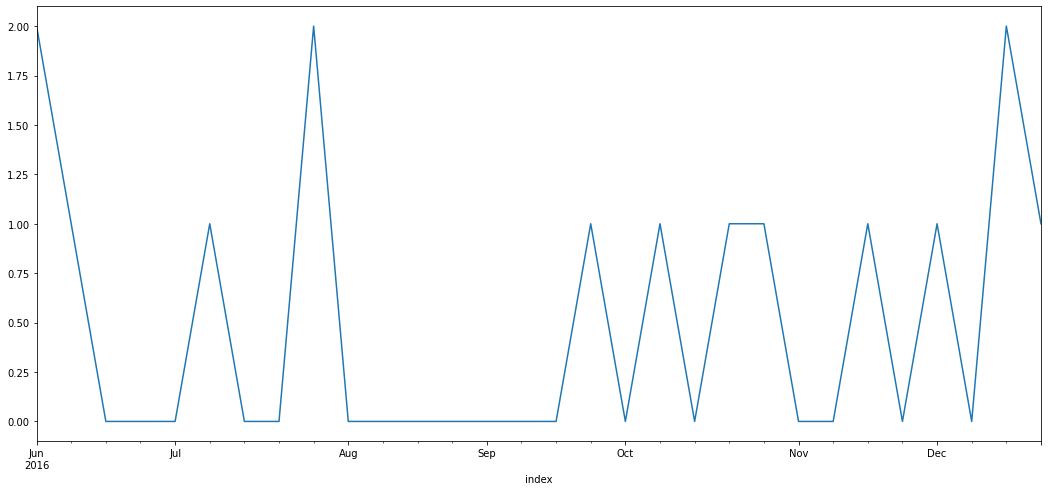

In [536]:
#plt.figure(figsize=(18,8))
#dataWeekly["2016-06":"2016"].rainday.plot() 

In [537]:
monthly = pd.DataFrame(data.groupby('ym')['rainy'].value_counts())
monthly.columns = ['Days']
monthly.reset_index(inplace = True)
monthly.columns = ['month', 'Rainy', 'Days']
monthly.replace({"Rainy": {True: "Wet", False:"Dry"}}, inplace=True)
monthly.head()
#data.merge(monthly, left_on='ym', right_on='month')
#temp.groupby('ym').max()
ndata=monthly.pivot(index ='month', columns ='Rainy')
#ndata.columns=ndata.columns.droplevel()
#ndata.fillna(0)
#ndata.head()
#data.merge(ndata, left_on='ym', right_on='month')
#data.head()
ndata=ndata.droplevel(0, axis=1) 
ndata.reset_index(inplace = True)
ndata=ndata.fillna(0)
dataX=data.merge(ndata, left_on='ym', right_on='month')
dataX.reset_index(inplace = True)
dataX=dataX.set_index(dataX['date'])
#dataX.index = pd.to_datetime(data.index)
#dataX.index.name="index"
dataX.drop(columns='index')
dataX.head()

,index,day,relative_humidity,rain_mm,rain_daily_hours,temp_f_max,date,ym,rainy,rainday,month,Dry,Wet
date,,,,,,,,,,,,,
2010-01-01,0,2010-01-01,96.0,0.03,0.0,34.0,2010-01-01,201001,False,0,201001,29.0,2.0
2010-01-02,1,2010-01-02,85.0,0.01,0.0,30.0,2010-01-02,201001,False,0,201001,29.0,2.0
2010-01-03,2,2010-01-03,60.0,0.00,0.0,9.0,2010-01-03,201001,False,0,201001,29.0,2.0
2010-01-04,3,2010-01-04,60.0,0.00,0.0,11.0,2010-01-04,201001,False,0,201001,29.0,2.0
2010-01-05,4,2010-01-05,60.0,0.00,0.0,13.0,2010-01-05,201001,False,0,201001,29.0,2.0


### Check dataset

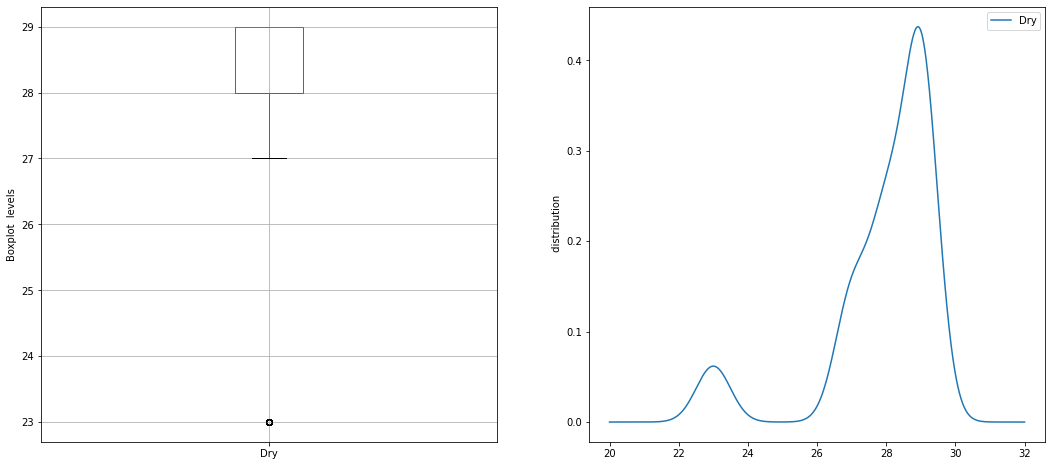

In [548]:
import numpy as np
import matplotlib.pyplot as plt
def plotBoxNdendity(data,col=None):
  if col in data.columns:    
    plt.figure(figsize=(18,8))

    ax1 = plt.subplot(121)
    data.boxplot(col,ax=ax1)
    ax1.set_ylabel('Boxplot  levels', fontsize=10)

    ax2 = plt.subplot(122)
    data[col].plot(ax=ax2,legend=True,kind='density')
    ax2.set_ylabel(' distribution', fontsize=10)

  else:
    print("Column not in the data")
plotBoxNdendity(dataX[:'2010'],'Dry')
#plotBoxNdendity(dataWeekly,'rainday')

In [540]:
#data.index = pd.to_datetime(data.index, unit='s')
#data['date']=pd.to_datetime(data['date'], infer_datetime_format=True)
#data.index = pd.to_datetime(data.index)
dataM=dataX.resample('M').max(); # monthly
dataM['2010-12':].tail()
#dataM[dataM.relative_humidity >= 98].head()

,index,day,relative_humidity,rain_mm,rain_daily_hours,temp_f_max,date,ym,rainy,rainday,month,Dry,Wet
date,,,,,,,,,,,,,
2018-03-31,3011,2018-03-31,100.0,2.30,15.0,52.0,2018-03-31,201803,True,1,201803,28.0,3.0
2018-04-30,3041,2018-04-30,100.0,1.29,5.0,57.0,2018-04-30,201804,True,1,201804,29.0,1.0
2018-05-31,3072,2018-05-31,100.0,0.82,4.0,70.0,2018-05-31,201805,True,1,201805,28.0,3.0
2018-06-30,3102,2018-06-30,100.0,1.15,3.0,75.0,2018-06-30,201806,True,1,201806,28.0,2.0
2018-07-31,3129,2018-07-27,100.0,1.17,5.0,78.0,2018-07-27,201807,True,1,201807,22.0,5.0


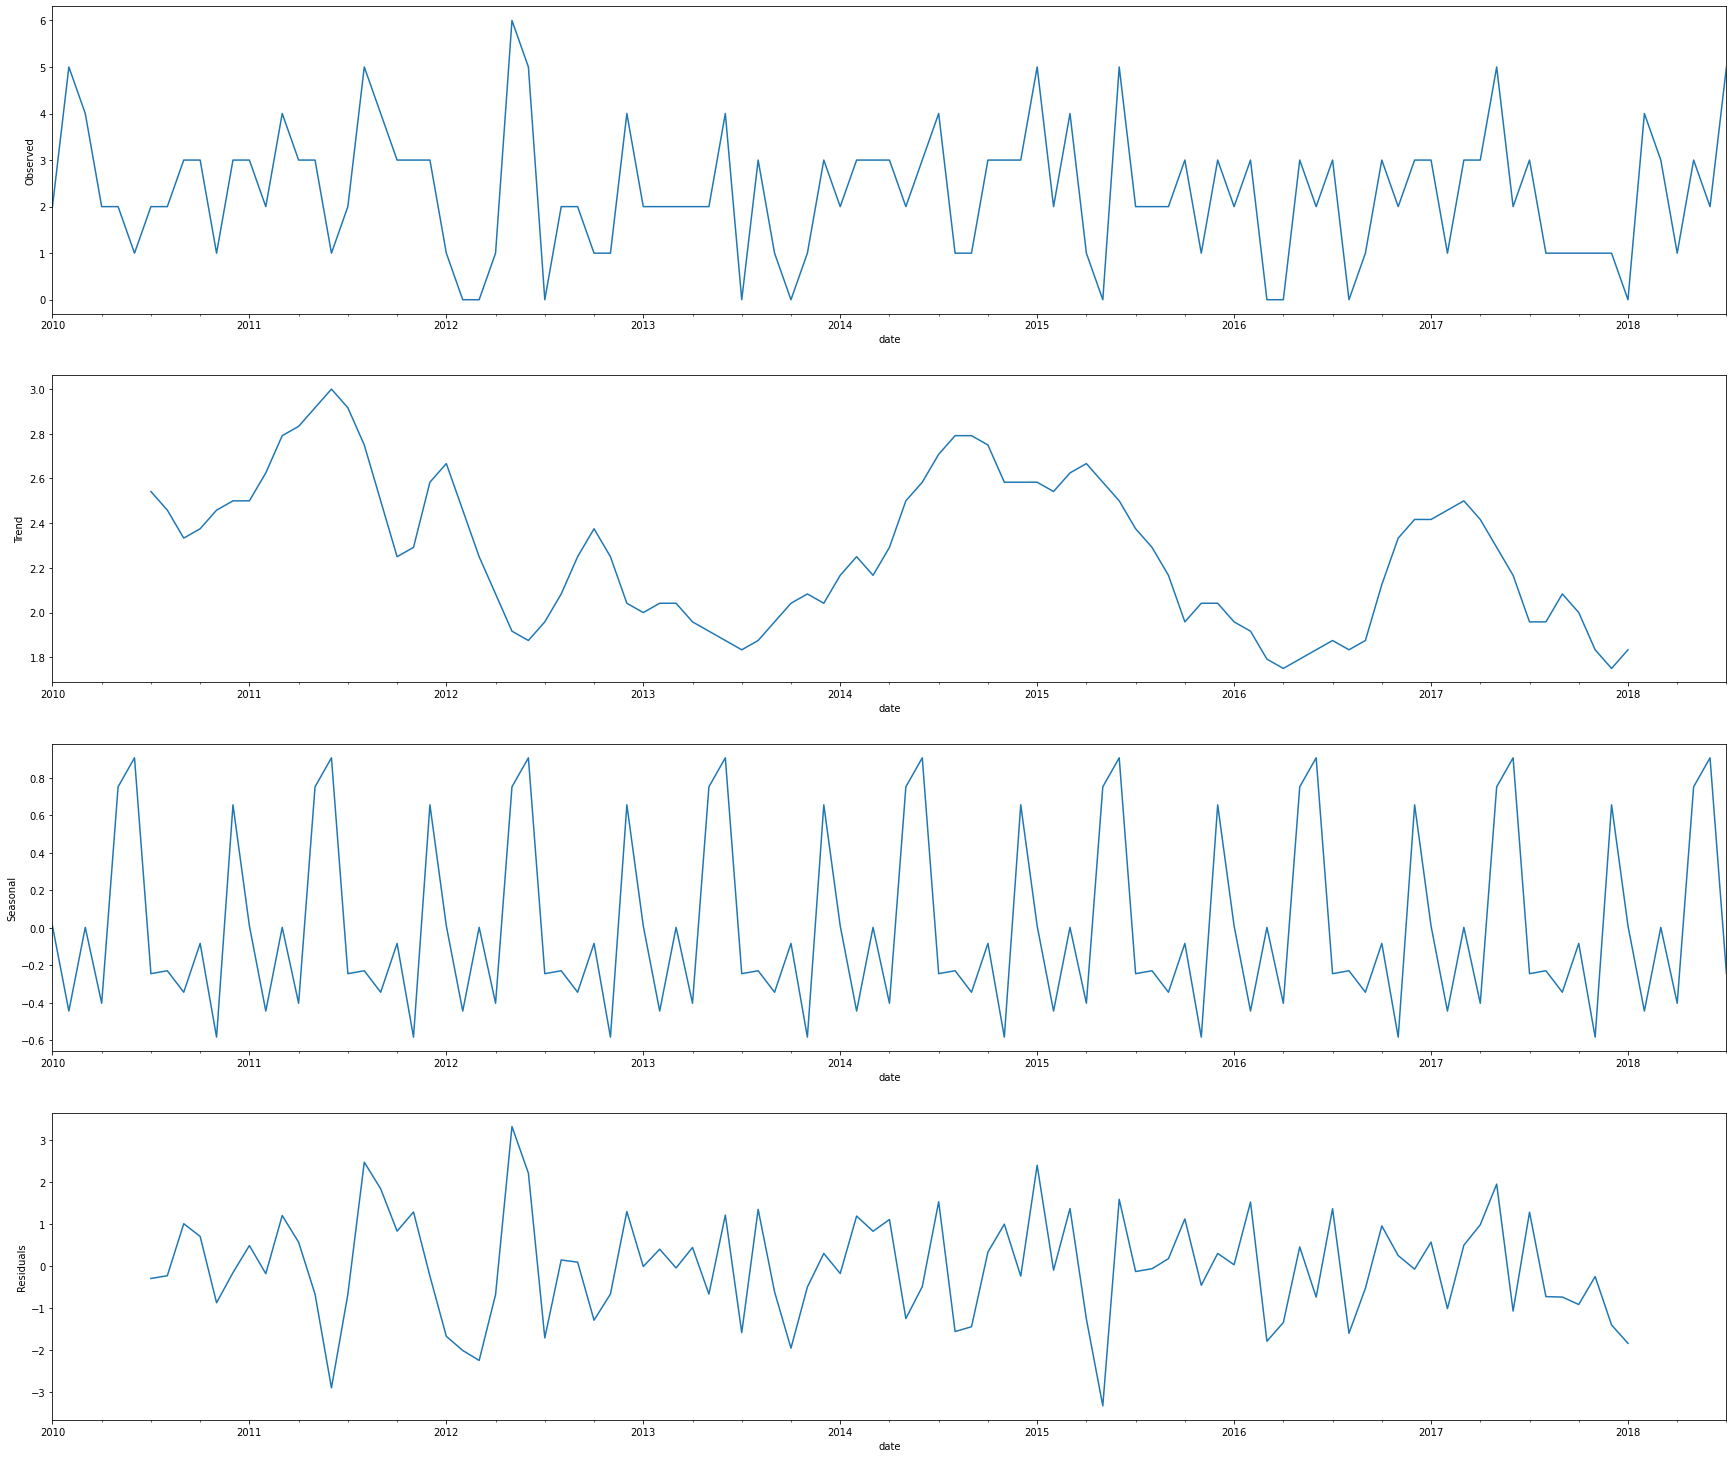

In [549]:
import statsmodels.api as sm
# Let's decompose the time series to visualize trend, season and noise seperately
def decomposeNplot(data):
  decomposition = sm.tsa.seasonal_decompose(data)

  plt.figure(figsize=(30,26))

  ax1 = plt.subplot(411)
  decomposition.observed.plot(ax=ax1)
  ax1.set_ylabel('Observed')

  ax2 = plt.subplot(412)
  decomposition.trend.plot(ax=ax2)
  ax2.set_ylabel('Trend')

  ax3 = plt.subplot(413)
  decomposition.seasonal.plot(ax=ax3)
  ax3.set_ylabel('Seasonal')

  ax4 = plt.subplot(414)
  decomposition.resid.plot(ax=ax4)
  ax4.set_ylabel('Residuals')

  return decomposition
#decomposeNplot(train['T (degC)'])
decomposeNplot(dataM['Wet'])
#decomposeNplot(dataWeekly['rainday'])

In [550]:
# Let's check for stationarity (Augmented Dickey Fuller test)
#“Stationary” usually refers to time series data. A timeseries is stationary if it has no drift/trend. 
#Equivalently, it's mean stays roughly constant. It's important because most statistical methods get weird 
#(and go wrong) when timeseries aren't stationary.
from statsmodels.tsa.stattools import adfuller
#results = adfuller(dataD)
#print(results)
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(dataX['Wet'])
adf_test(dataWeekly['rainday'])

Results of Dickey-Fuller Test:
Test Statistic                -6.728031e+00
p-value                        3.350750e-09
#Lags Used                     0.000000e+00
Number of Observations Used    3.129000e+03
Critical Value (1%)           -3.432442e+00
Critical Value (5%)           -2.862464e+00
Critical Value (10%)          -2.567262e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -21.865749
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    447.000000
Critical Value (1%)             -3.445064
Critical Value (5%)             -2.868028
Critical Value (10%)            -2.570226
dtype: float64


### Create Model

In [577]:
## Resampling the data to mothly and averaging out the temperature & we will predict the monthly average temperature
train = dataM[:'2016']
test =  dataM['2016':]
alldata=dataM[:'2018-01']['Dry']
#alldata=dataM[:'2017-07']['Dry']
ftraindata = train['Dry']
ftestdata = test['Dry']


#dataWeekly['rainday']
#train = dataWeekly['2015':'2016']
#test =  dataWeekly['2016':]
#alldata=dataM['dataWeekly']
#alldata=dataWeekly['2015':'2018-04']['rainday']
#ftraindata = train['rainday']
#ftestdata = test['rainday']

from statsmodels.tsa.statespace.sarimax import SARIMAX
#endog.index = endog.datetime
#
#endog = endog.drop(['T (degC)'])

#exog.index = exog.dates
#exog = exog.drop(['dates'], axis = 1)
#Weekly 
#model = SARIMAX(alldata,order=(2,0,2),seasonal_order=(1,1,0,52),trend='ct', freq='W')#,endog = dataW  ,exog=dataW,
#Monthly
model = SARIMAX(alldata,order=(2, 0, 2),seasonal_order=(1, 1, 0, 12),trend='n',  freq='M', enforce_stationarity=True)

#model = SARIMAX(ftraindata,order=(1, 0, 1),seasonal_order=(2, 1, 0, 367),trend='n',   enforce_stationarity=True)
#model = SARIMAX(ftraindata,order=(2, 0, 2),seasonal_order=(1, 1, 0, 1),trend='n',freq='W',  enforce_stationarity=True)
#model = SARIMAX(data['relative_humidity'],order=(2,0,2),seasonal_order=(1,1,0,365),trend='n',freq='D',enforce_stationarity=True)
#modelrh = SARIMAX(ftraindatarh,order=(2,0,2),seasonal_order=(1,1,0,52),trend='n',enforce_stationarity=True)
#model = SARIMAX(dataM['Dry'],order=(2,0,2),trend='n',freq='M',enforce_stationarity=True)
#(2, 0, 2)xh(1, 1, 0, 52)
results = model.fit()
print(np.mean(np.abs(results.resid)))
results.summary()

4.668483017308183


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 Dry   No. Observations:                   97
Model:             SARIMAX(2, 0, 2)x(1, 1, [], 12)   Log Likelihood                -166.591
Date:                             Wed, 22 Apr 2020   AIC                            345.182
Time:                                     23:03:41   BIC                            359.837
Sample:                                 01-31-2010   HQIC                           351.077
                                      - 01-31-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1080      0.437      2.534      0.011       0.251       1.965
ar.L2         -0.2222      0.423     -0.526      0.599      -1.051       0.607
ma.L1         -0.9264      0.493     -1.878      0.060      -1.893       0.041
ma.L2         -0.0332      0.479     -0.069      0.945      -0.972       0.906
ar.S.L12      -0.3797      0.108     -3.509      0.000      -0.592      -0.168
sigma2         2.8588      0.546      5.232      0.000       1.788       3.930
===================================================================================
Ljung-Box (Q):                       29.80   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.88   Prob(JB):                         0.54
Heteroskedasticity (H):               0.80   Skew:                            -0.22
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [578]:
forecast = results.get_forecast(steps=24)#len(ftestdata))
forecast.predicted_mean.head(10).round()
#results(1).plot_diagnostics(figsize=(10,10))
#results.summary()
#forecast.conf_int().round()
#forecast.conf_int().iloc[:,0].round()

2018-02-28    27.0
2018-03-31    29.0
2018-04-30    28.0
2018-05-31    26.0
2018-06-30    28.0
2018-07-31    28.0
2018-08-31    30.0
2018-09-30    29.0
2018-10-31    29.0
2018-11-30    28.0
Freq: M, dtype: float64

In [579]:
#plt.figure(figsize=(12,8))
#dataM['2010':]['Dry'].plot()
#dataM['2017':]

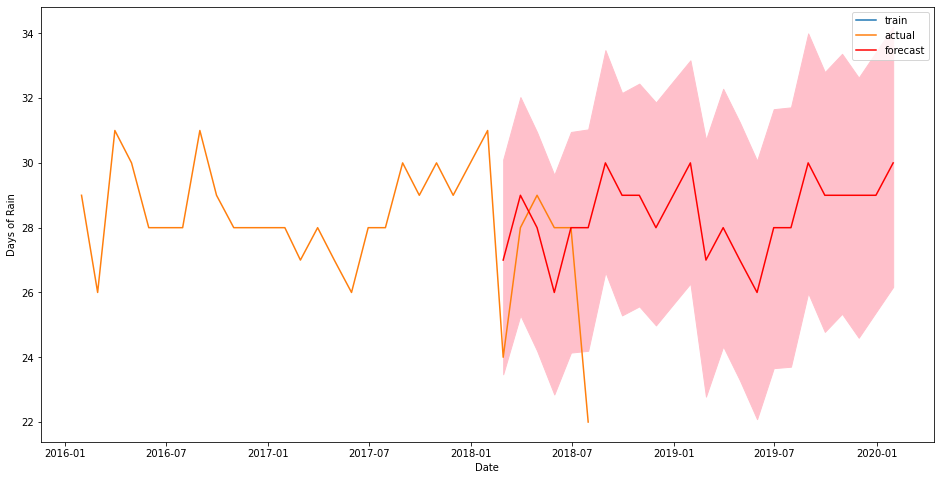

2018-02-28    27.0
2018-03-31    29.0
2018-04-30    28.0
2018-05-31    26.0
2018-06-30    28.0
Freq: M, dtype: float64

In [580]:

train = dataM[:'2015']

test =  dataM['2015':'2016']
alldata=dataM['2016':]['Dry']
ftraindata = train['2016':]['Dry']
ftestdata = test['Dry']

#dataWeekly['rainday']
#train = dataWeekly['2016':'2016']
#test =  dataWeekly['2016':]
#alldata=dataWeekly['2016-07':].rainday
#alldata=dataWeekly[:'2017-07']['rainday']
#ftraindata = train['rainday']
#ftestdata = test['rainday']

bounds = forecast.conf_int()
lower_limit = bounds.iloc[:,0]
upper_limit = bounds.iloc[:,1]
plt.figure(figsize=(16,8))

plt.plot(ftraindata.index, ftraindata, label='train')
plt.plot(alldata.index,alldata,label='actual')

plt.plot(forecast.predicted_mean.index, forecast.predicted_mean.round(), color='r', label='forecast')

plt.fill_between(lower_limit.index,lower_limit,upper_limit, color='pink')

plt.xlabel('Date')
plt.ylabel('Days of Rain')
plt.legend()
plt.show()
#predictedmean.head().round()
forecast.predicted_mean.head().round()

#### Next steps

- Close this notebook.
- Open the `Part 2 - Data Analysis` notebook to explore the cleaned dataset.

<a id="authors"></a> 
### Authors

This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>